# CycleGAN: Monet Style Transfer
By Sheraz Mahmood

Kaggle Competition: https://kaggle.com/competitions/gan-getting-started

## **Objective**

The goal of this project is to build a deep learning model capable of converting real-world photographs into Monet-style paintings. We aim to replicate not just the color palette, but also the textural brushstroke patterns and vibrant impressionistic style characteristic of Claude Monet's artwork. The final output should not only be visually convincing but stylistically faithful to Monet's work.

## **Approach**

We implement a few slightly modified CycleGAN architectures.
- Two Generators: Photo to Monet then Monet to Photo
- Two Discriminators: one to discriminate Monet pictures and one to discriminate real photos
- Cycle Consistency: to preserve content during translation
- Identity and Adversarial loss

To improve the generators output we attempted:
- Perceptual loss using VGG19 this is to encourage high-level visual features alignment
- Colorfulness loss to mtain Monet's vibrat and saturated color style
- UpSampling vs. Conv2DTranspose to reduce checkerboard appearance.


Major challange is the brush strokes, the texture expressive, layered brush strokes.

In [3]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import  layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/CU/CycleGAN/gan-getting-started/'

monet_dir = base_path + 'monet_jpg/'
photo_dir = base_path + 'photo_jpg/'
test_dir = base_path + 'test_jpg/'


Mounted at /content/drive


In [4]:
# Image parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 4  # doing anything else beyond this will throw an out of memory error

def load_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_dataset(folder):
    filenames = tf.io.gfile.glob(os.path.join(folder, '*.jpg'))
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
monet_ds = load_dataset(monet_dir)
photo_ds = load_dataset(photo_dir)
train_dataset = tf.data.Dataset.zip((photo_ds, monet_ds))



In [17]:
# Count the number of samples in each dataset
monet_count = sum(1 for _ in monet_ds.unbatch())
photo_count = sum(1 for _ in photo_ds.unbatch())

data_summary = pd.DataFrame({
    'Category': ['Monet Images', 'Photo Images'],
    'Count': [monet_count, photo_count]
})

print(data_summary.to_string(index=False))


    Category  Count
Monet Images    300
Photo Images   7038


In [5]:
for photo, monet in train_dataset.take(1):
    print("Photo shape:", photo.shape)
    print("Monet shape:", monet.shape)


Photo shape: (4, 256, 256, 3)
Monet shape: (4, 256, 256, 3)


In [6]:
def show_image(img):
    img = (img + 1.0) / 2.0  # back to [0, 1]
    plt.imshow(img)
    plt.axis("off")
    plt.show()



In [8]:
def colorfulness_metric(image):
    image = (image + 1.0) * 127.5  # Convert to [0, 255]

    r, g, b = tf.split(image, 3, axis=-1)

    rg = tf.abs(r - g)
    yb = tf.abs(0.5 * (r + g) - b)

    rg_mean = tf.reduce_mean(rg)
    yb_mean = tf.reduce_mean(yb)

    score = tf.sqrt(rg_mean**2 + yb_mean**2 + 1e-5)

    return score

# EDA Analysis

For our EDA analysis we will look at three factors.

1. Colorfulness: Are Monets more colorful vs real images? Check avg colorfulness.
2. Brightness Distribution: Do Monets differ in luminance or dynamic range? Check avg brightness per image.
3. Saturation/Contrast Distribution: Compare histograms of saturation and contrast between real vs Monet images.


### Dataset Summary

Our training dataset consists of two distinct image domains: real-world photographs and Monet-style paintings. The distribution is:

| Category      | Count |
|---------------|-------|
| Monet Images  | 300   |
| Photo Images  | 7038  |

Each image has been resized to a resolution of 256x256 pixels with 3 color channels (RGB).

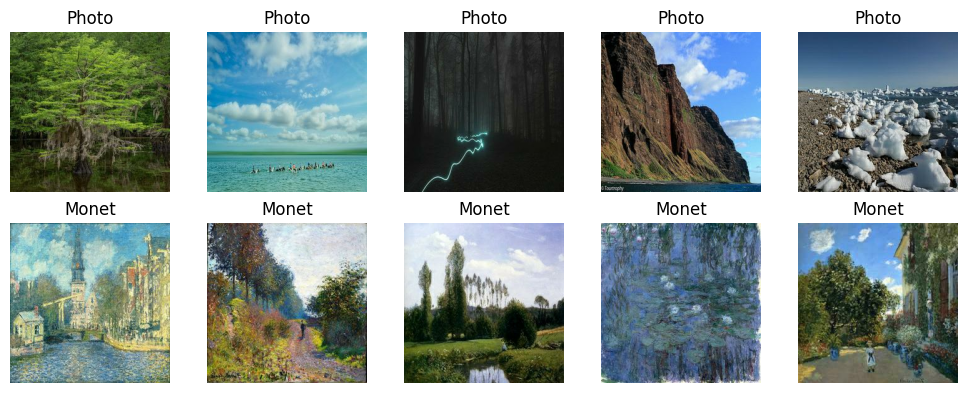

In [11]:
def show_real_vs_monet(photo_ds, monet_ds, num_images=5):
    photo_iter = iter(photo_ds.unbatch().take(num_images))
    monet_iter = iter(monet_ds.unbatch().take(num_images))

    plt.figure(figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Photo (real-world image)
        photo = next(photo_iter)
        photo = (photo + 1.0) / 2.0  # Convert back to [0, 1]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(photo)
        plt.title("Photo")
        plt.axis("off")

        # Monet-style painting
        monet = next(monet_iter)
        monet = (monet + 1.0) / 2.0
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(monet)
        plt.title("Monet")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_real_vs_monet(photo_ds, monet_ds, num_images=5)


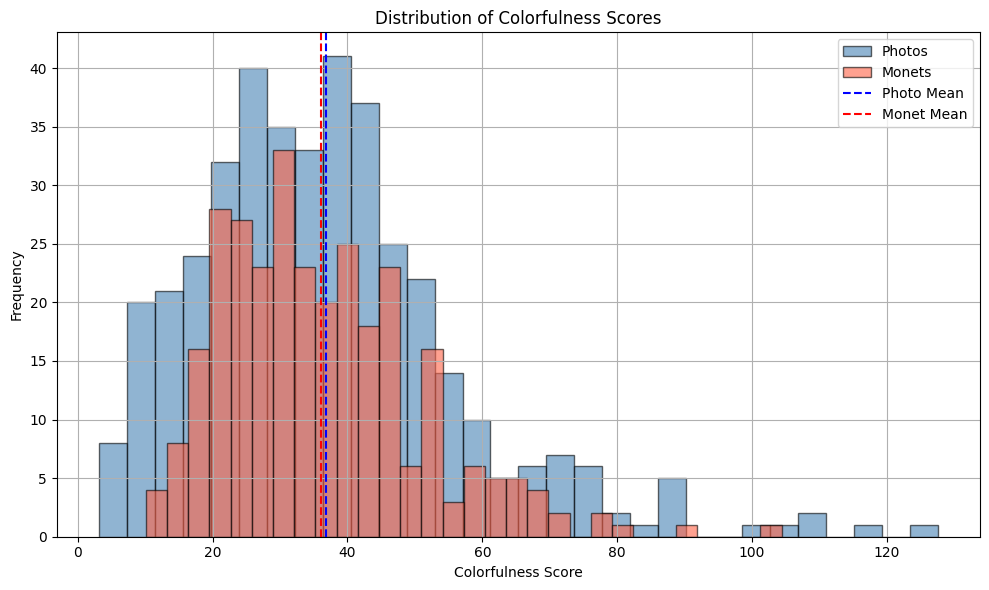

In [14]:
def compute_colorfulness_scores(dataset, label, max_batches=100):
    scores = []
    for batch in dataset.take(max_batches):
        for img in batch:
            score = colorfulness_metric(tf.expand_dims(img, axis=0)).numpy()
            scores.append(score)
    return scores


photo_scores = compute_colorfulness_scores(photo_ds, "Photo")
monet_scores = compute_colorfulness_scores(monet_ds, "Monet")

# Plot overlapping histogram
plt.figure(figsize=(10, 6))
plt.hist(photo_scores, bins=30, alpha=0.6, label="Photos", color='steelblue', edgecolor='black')
plt.hist(monet_scores, bins=30, alpha=0.6, label="Monets", color='tomato', edgecolor='black')
plt.axvline(np.mean(photo_scores), color='blue', linestyle='--', label='Photo Mean')
plt.axvline(np.mean(monet_scores), color='red', linestyle='--', label='Monet Mean')
plt.xlabel("Colorfulness Score")
plt.ylabel("Frequency")
plt.title("Distribution of Colorfulness Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


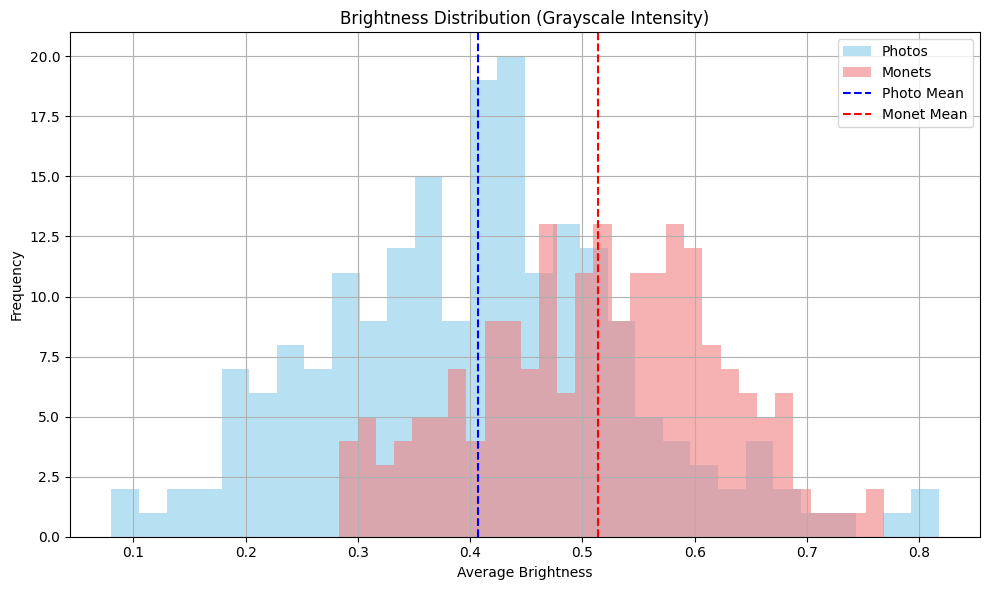

In [15]:
def compute_brightness(image):
    image = (image + 1.0) / 2.0  # Convert from [-1, 1] to [0, 1]
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    return tf.reduce_mean(image).numpy()

def compute_brightness_scores(dataset, label, max_batches=50):
    scores = []
    for batch in dataset.take(max_batches):
        for img in batch:
            score = compute_brightness(img)
            scores.append(score)
    return scores

photo_brightness = compute_brightness_scores(photo_ds, "Photo")
monet_brightness = compute_brightness_scores(monet_ds, "Monet")

plt.figure(figsize=(10, 6))
plt.hist(photo_brightness, bins=30, alpha=0.6, label='Photos', color='skyblue')
plt.hist(monet_brightness, bins=30, alpha=0.6, label='Monets', color='lightcoral')

plt.axvline(np.mean(photo_brightness), color='blue', linestyle='dashed', label='Photo Mean')
plt.axvline(np.mean(monet_brightness), color='red', linestyle='dashed', label='Monet Mean')

plt.title('Brightness Distribution (Grayscale Intensity)')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


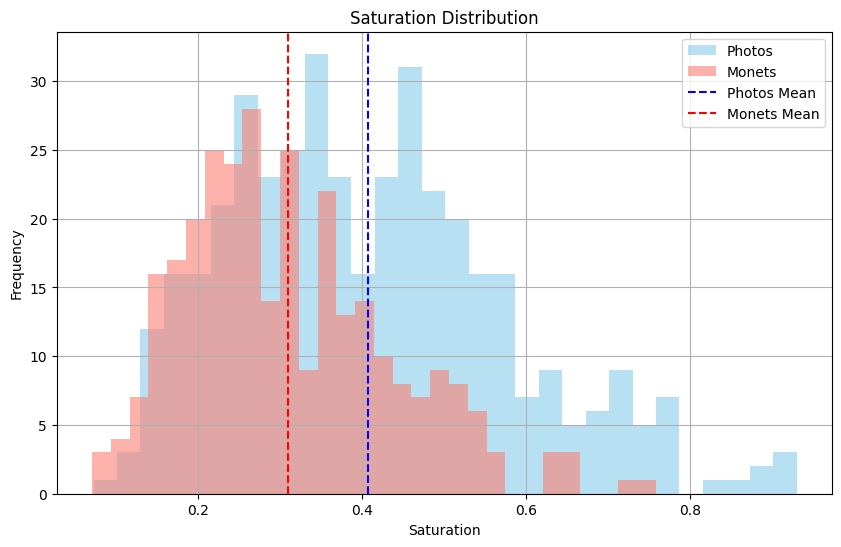

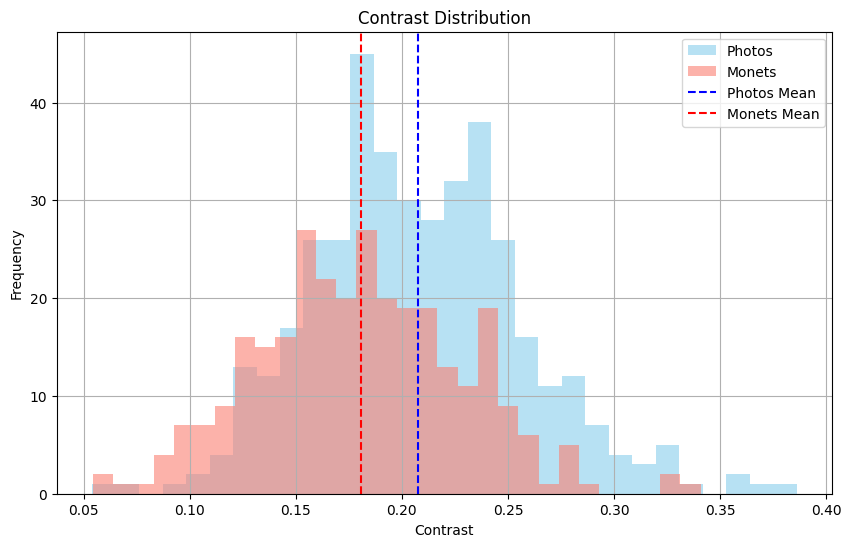

In [16]:
def compute_saturation(img):
    hsv = tf.image.rgb_to_hsv((img + 1.0) / 2.0)  # Normalize to [0,1]
    return tf.reduce_mean(hsv[..., 1])  # Saturation channel

def compute_contrast(img):
    img_gray = tf.image.rgb_to_grayscale((img + 1.0) / 2.0)  # [0,1]
    return tf.math.reduce_std(img_gray)

def compute_scores(dataset, metric_fn, label, max_batches=100):
    scores = []
    for batch in dataset.take(max_batches):
        for img in batch:
            score = metric_fn(img).numpy()
            scores.append(score)
    return scores

saturation_photos = compute_scores(photo_ds, compute_saturation, "Photos")
saturation_monets = compute_scores(monet_ds, compute_saturation, "Monets")

contrast_photos = compute_scores(photo_ds, compute_contrast, "Photos")
contrast_monets = compute_scores(monet_ds, compute_contrast, "Monets")

# Plot histograms
def plot_comparison_histogram(data1, data2, label1, label2, metric_name):
    plt.figure(figsize=(10, 6))
    plt.hist(data1, bins=30, alpha=0.6, label=label1, color='skyblue')
    plt.hist(data2, bins=30, alpha=0.6, label=label2, color='salmon')
    plt.axvline(np.mean(data1), color='blue', linestyle='--', label=f'{label1} Mean')
    plt.axvline(np.mean(data2), color='red', linestyle='--', label=f'{label2} Mean')
    plt.title(f'{metric_name} Distribution')
    plt.xlabel(f'{metric_name}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparison_histogram(saturation_photos, saturation_monets, "Photos", "Monets", "Saturation")
plot_comparison_histogram(contrast_photos, contrast_monets, "Photos", "Monets", "Contrast")


#EDA Analysis
## Colorfulness Observations

- Monet images are not consistently more colorful than real photos
- Monet paintings not highly saturated

We will use colorfulness as a metric but it most likly is not something that can be used to bring out monet features.

## Brightness Observations
- Monet images tend to be brghter vs real photos on average
- Mean brightness for Monet paintings is shifted to the right compared to real-world photos
- Adding brightness related loss terms may help the generator produce more Monet style results

## Saturation and Contrast Distributions
- Significant overlap in both saturation and constrast
- May not be a helpful metric to diffrientiate and create Monet style images

#Generator
Similar to an autoencoder, the generator is composed of an encoder-transformer-decoder.

**Encoder**: Takes the input image (say 256x256x3) and compress it into a lower-resolution, high-depth feature map (64x64x256).

**Transformer**: (not like Attention-based Transformer) transforms feature representations from the Encoder into new feature representations that will later be decoded into a new image.  This is necessary to modify/adjust the contents (style, texture, color etc).  It perserves key structures: edges, layouts, object boundaries.

**Decoder**: Takes the transformed feature map and upsamples them back to 256x256x3 final stylized image.




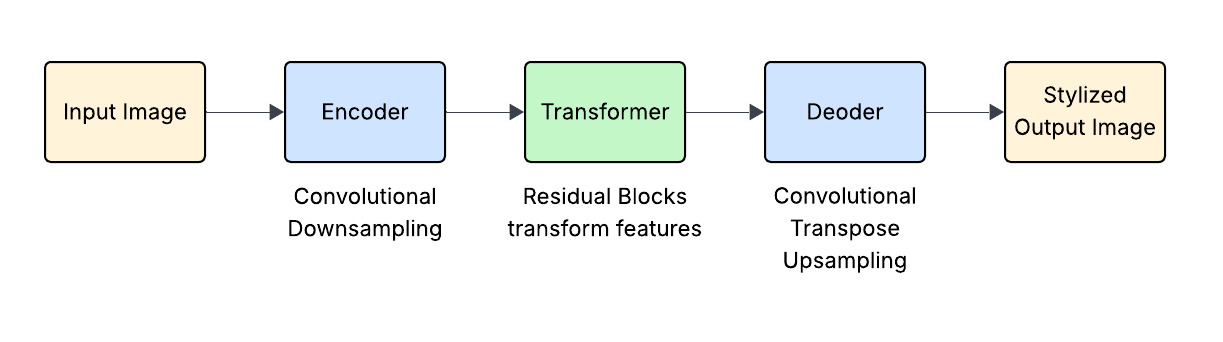

##Two Generators

Generator F: Monet Picture to Real Photo
Generator G: Real Photo to Monet Picture

These are two independent models that train to build their best pictures

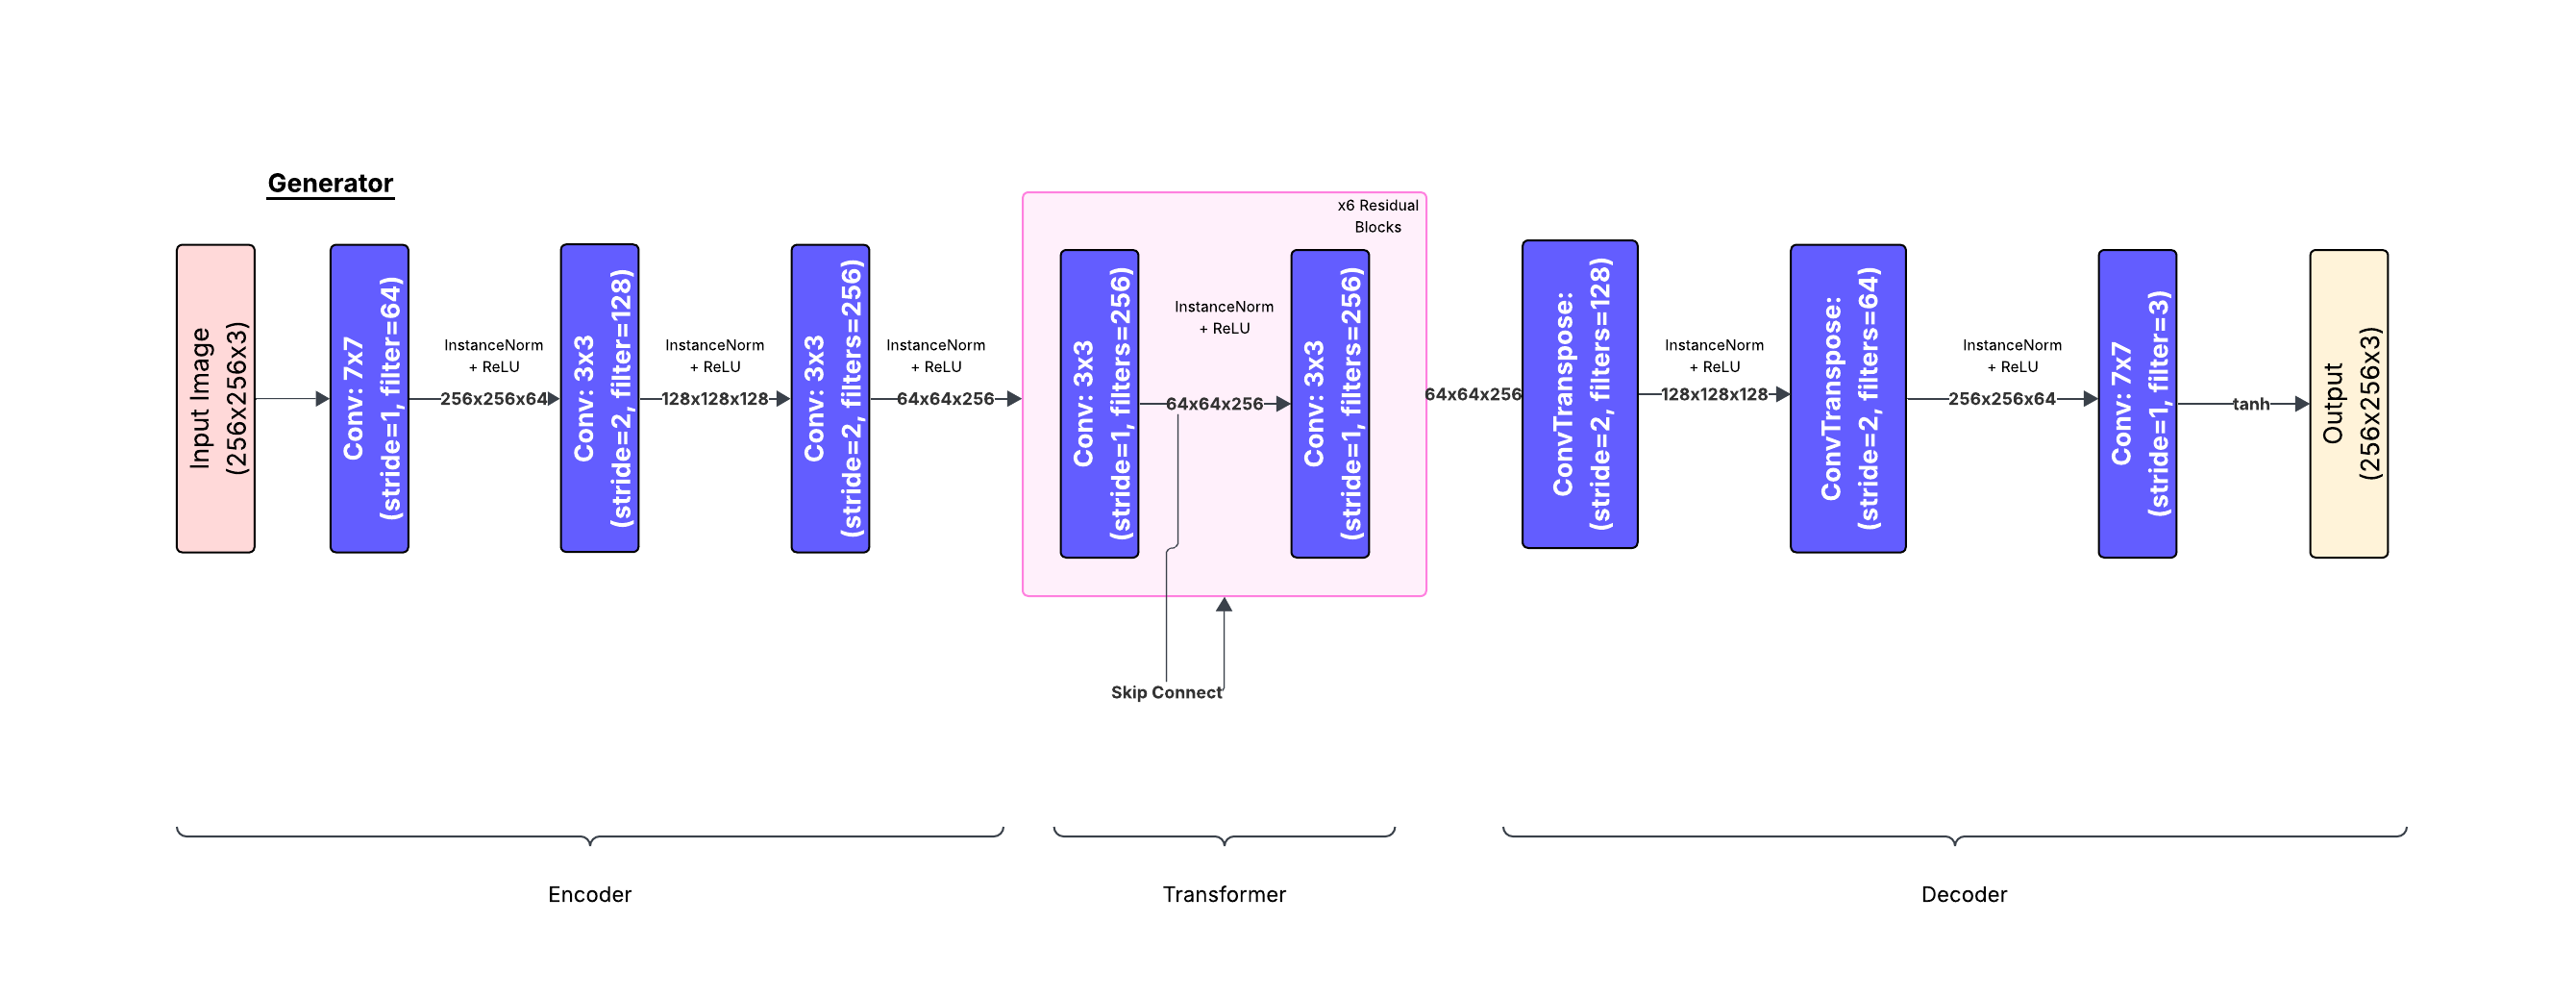

#Discriminator

PatchGAN: Judges small patches of an image stead of the whole image.  Zoom into 70x70 pixels at a time and see if they look real.  

The 256x256 input image is downsampled through strided convolutions to a 30x30 grid, where each output unit judges whether a 70x70 field in the original image is real or fake.

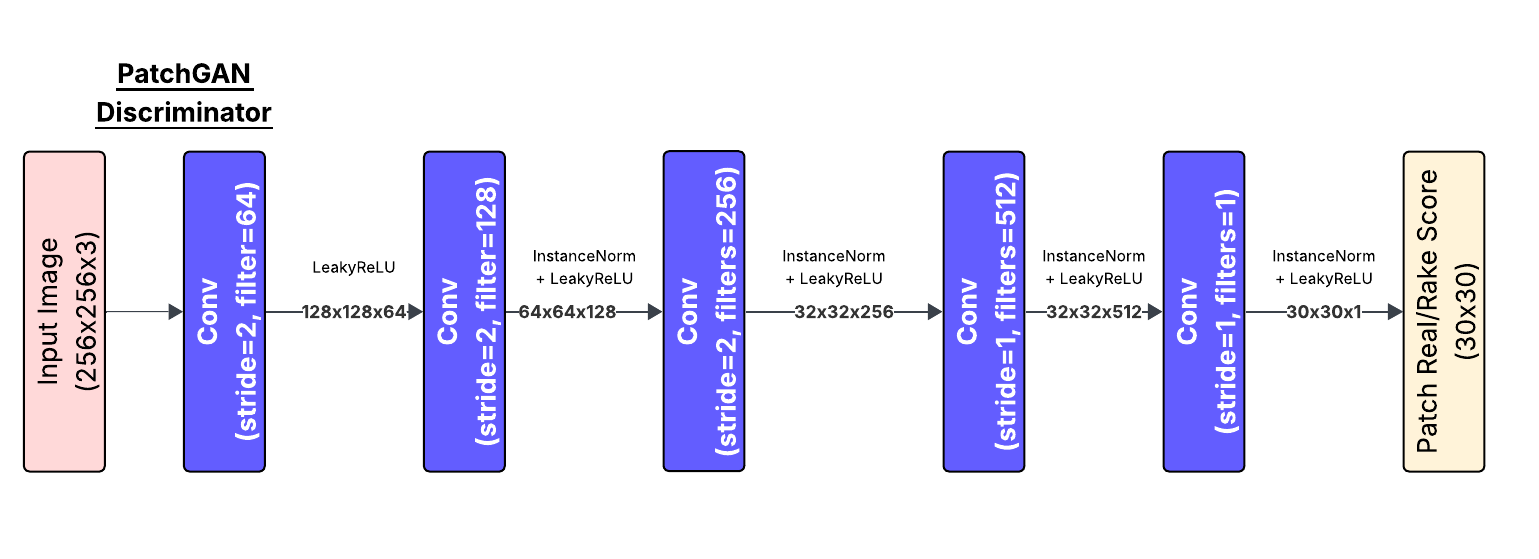


## 1. **Adversarial Loss**
**Make fake images fool the Discriminators into thinking they are real**.

For Generator \( G \) (Photo → Monet):
- Generate \( G(x) \) (Fake Monet from Real Photo \( x \)).
- Discriminator \( $D_Y$ \) should classify \( G(x) \) as **real Monet**.

For Generator \( F \) (Monet → Photo):
- Generate \( F(y) \) (Fake Photo from Real Monet \( y \)).
- Discriminator \( $D_X$ \) should classify \( F(y) \) as **real Photo**.

Using Least Squares GAN (LSGAN) loss (more stable than classic GAN):

For G:
$
\mathscr{L}_{GAN}(G, D_Y, x, y) = \mathbb{E}_{x \sim p_{data}(x)}[(D_Y(G(x)) - 1)^2]
$

For F:
$
\mathscr{L}_{GAN}(F, D_X, y, x) = \mathbb{E}_{y \sim p_{data}(y)}[(D_X(F(y)) - 1)^2]
$

G tries to make $D_Y$ think G(x) is real
F tries to make $D_X$ think F(y) is real

## 2. **Cycle Consistency Loss**
**After translating and then translating back, the result should match the original.**

- Translate Photo → Monet → Photo again:
  $F(G(x)) \approx x$
- Translate Monet → Photo → Monet again:
  $G(F(y)) \approx y$

Cycle consistency loss:

$\mathscr{L}_{cyc}(G, F) = \mathbb{E}_{x \sim p_{data}(x)}[||F(G(x)) - x||_1] + \mathbb{E}_{y \sim p_{data}(y)}[||G(F(y)) - y||_1]
$

It's an **L1 Loss (Mean Absolute Error)**.  
It forces **content and structure preservation** across cycles.

## 3. **Identity Loss**
**If the input is already in the target domain, the generator shouldn't change it.**

Examples:
- Feed a real Monet $y$ into Generator $G$ (Photo→Monet):  
  - It should just output the **same Monet**.
- Feed a real Photo $x$ into Generator $F$ (Monet→Photo):  
  - It should just output the **same Photo**.

Identity loss:

$\mathscr{L}_{identity}(G, F) = \mathbb{E}_{y \sim p_{data}(y)}[||G(y) - y||_1] + \mathbb{E}_{x \sim p_{data}(x)}[||F(x) - x||_1]$

Again **L1 Loss**.

Helps generators to **not over-transform** images when unnecessary.

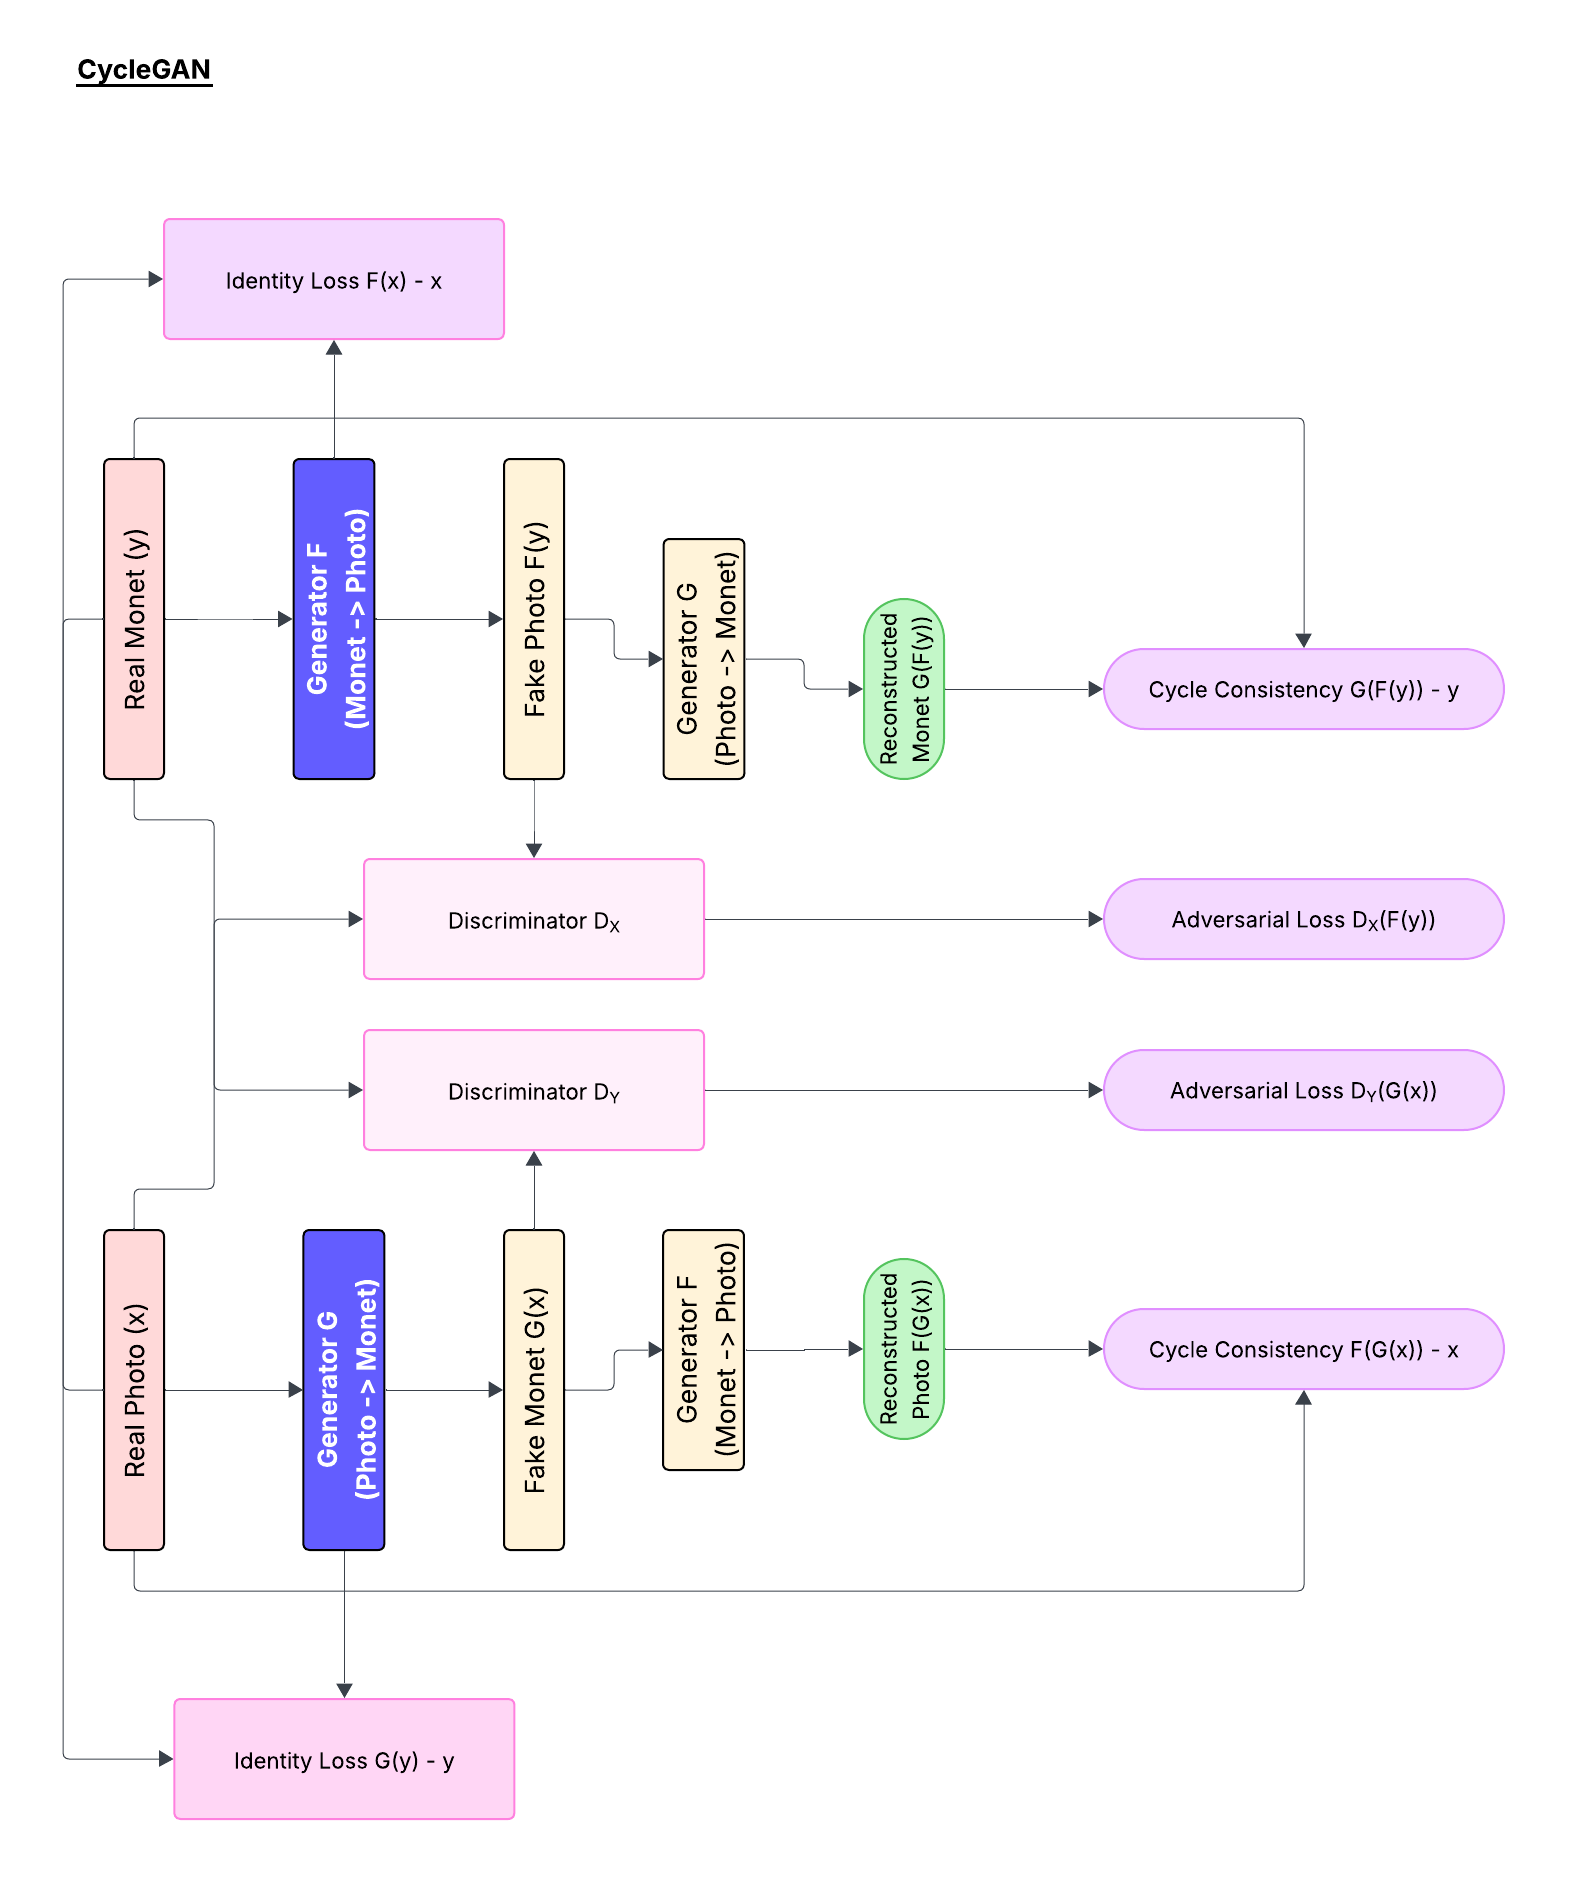

The original GAN papers (Goodfellow et al., 2014) and CycleGAN (Zhu et al., 2017) observed during experiments that adversarial losses settle around ~0.1-1.0. Cycle Consistency and Identity losses are bigger at ~10-100.  We can use this to normalize our numbers.

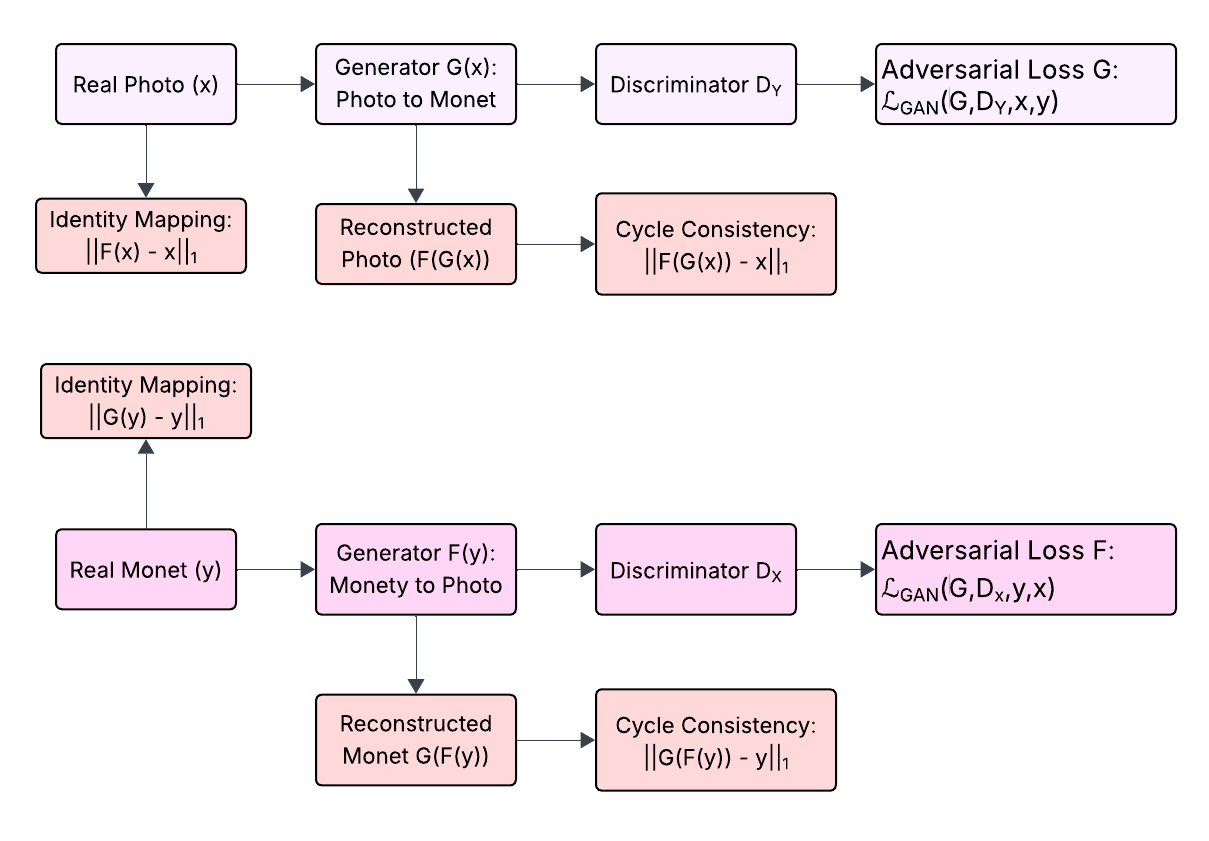

#**CycleGAN Generator Loss Formula**

For Generator $G$ and Generator $F$:

$
\mathscr{L}_{G} = \mathscr{L}_{GAN}(G, D_Y, X, Y) + \lambda_{cyc} \mathscr{L}_{cyc}(G, F) + \lambda_{identity} \mathscr{L}_{identity}(G)
$

$
\mathscr{L}_{F} = \mathscr{L}_{GAN}(F, D_X, Y, X) + \lambda_{cyc} \mathscr{L}_{cyc}(G, F) + \lambda_{identity} \mathscr{L}_{identity}(F)
$

Where:
- $ \lambda_{cyc} $ is usually **10.0** (strong cycle enforcement)
- $ \lambda_{identity} $ is often $0.5 \times \lambda_{cyc}$ (identity loss weighted lower)

# **Discriminator Losses**

Each Discriminator has its own adversarial loss:

For $D_Y$:
$
\mathscr{L}_{D_Y} = \frac{1}{2}\left[(D_Y(y) - 1)^2 + (D_Y(G(x)))^2\right]
$

For $D_X$:
$
\mathscr{L}_{D_X} = \frac{1}{2}\left[(D_X(x) - 1)^2 + (D_X(F(y)))^2\right]
$

Discriminator tries to:
- Predict **1** for real images,
- Predict **0** for fake images.

i

In [7]:
# Build our convolution layer with InstanceNorm + Relu
class InstanceNormalization(layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon
  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer='ones',
        trainable=True
    )
    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True
    )
  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

def conv_layer(x, filters=256, kernel_size=3, strides=1,padding='same', apply_instance_and_relu = True, use_leaky_relu=False):
  x = layers.Conv2D(
      filters=filters,
      kernel_size=kernel_size,
      strides=strides,
      padding=padding,
      use_bias=False
  )(x)
  if apply_instance_and_relu:
    x = InstanceNormalization()(x)
    if not use_leaky_relu:
      x = layers.ReLU()(x)
    else:
      x= layers.LeakyReLU()(x)
  return x
def residual_block(x):
  shortcut = x
  x = conv_layer(x, filters=256, kernel_size=3, strides=1, padding='same')
  x = layers.Conv2D(
      filters=256,
      kernel_size=3,
      strides=1,
      padding='same',
  )(x)
  x = layers.Add()([x, shortcut])
  return x

def build_transfomer(x, blocks):
  for _ in range(blocks):
    x = residual_block(x)
  return x

def conv_transpose_block(x, filters=256, kernel_size=3, strides=2, padding='same'):
  x = layers.Conv2DTranspose(
      filters=filters,
      kernel_size=kernel_size,
      strides=strides,
      padding=padding)(x)
  x = InstanceNormalization()(x)
  x = layers.ReLU()(x)
  return x

def upsampling_conv_block(x, filters=256, kernel_size=3, strides=2, padding='same'):
  x = layers.UpSampling2D(size=strides)(x)
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
  x = InstanceNormalization()(x)
  x = layers.ReLU()(x)
  return x

def build_encoder(input):
  x = conv_layer(input, filters=64, kernel_size=7, strides=1, padding='same')
  x = conv_layer(x, filters=128, kernel_size=3, strides=2, padding='same')
  x = conv_layer(x, filters=256, kernel_size=3, strides=2, padding='same')
  return x
def build_decoder(x,input_mage):
  x = conv_transpose_block(x, filters=128, kernel_size=3, strides=2, padding='same')
  x = conv_transpose_block(x, filters=64, kernel_size=3, strides=2, padding='same')
  input_processed = conv_layer(input_mage, filters=64, kernel_size=7, strides=1, padding='same')
  x = layers.Concatenate()([x, input_processed])
  x = conv_layer(x, filters=3, kernel_size=7, strides=1, padding='same', apply_instance_and_relu=False)
  x = layers.Activation('tanh')(x)
  return x

def build_generator():
  inputs = layers.Input(shape=(256, 256, 3))
  encoder = build_encoder(inputs)
  transfomer = build_transfomer(encoder, blocks=9)
  decoder = build_decoder(transfomer, inputs)
  return models.Model(inputs=inputs, outputs=decoder)

def build_discriminator():
  input = layers.Input(shape=(256,256,3))
  x = conv_layer(input, filters=64,strides=2,use_leaky_relu=True)
  x = conv_layer(x, filters=128,strides=2,use_leaky_relu=True)
  x = conv_layer(x, filters=256,strides=2,use_leaky_relu=True)
  x = conv_layer(x, filters=512,strides=1,use_leaky_relu=True)
  x = conv_layer(x, filters=1,strides=1,apply_instance_and_relu=False)
  return models.Model(inputs=input, outputs=x)




In [8]:
G = build_generator()       # X -> Y (Photo -> Monet)
F = build_generator()   # Y -> X (Monet -> Photo)
D_Y = build_discriminator() # Discriminator for Monet (Y)
D_X = build_discriminator() # Discriminator for Photo (X)

mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



In [9]:
class LinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, start_decay_epoch, total_epochs):
        self.initial_lr = initial_lr
        self.start_decay_epoch = start_decay_epoch
        self.total_epochs = total_epochs

    def __call__(self, epoch):
        if epoch < self.start_decay_epoch:
            return self.initial_lr
        decay_epochs = self.total_epochs - self.start_decay_epoch
        decay = (epoch - self.start_decay_epoch) / decay_epochs
        return self.initial_lr * (1.0 - decay)


In [11]:
# Extract intermediate features
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
vgg_feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

def preprocess_for_vgg(x):
    x = (x + 1.0) * 127.5  # [-1, 1] → [0, 255]
    return tf.keras.applications.vgg19.preprocess_input(x)


def perceptual_loss(real, generated):
    real_vgg = vgg_feature_extractor(preprocess_for_vgg(real))
    gen_vgg = vgg_feature_extractor(preprocess_for_vgg(generated))
    return tf.reduce_mean(tf.abs(real_vgg - gen_vgg))




80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
def train_step(real_x, real_y, lambda_cycle=10.0, lambda_identity=5.0):
  # real_x: a real photo
  # real_y: a real Monet painting

  with tf.GradientTape(persistent=True) as tape:
    fake_y = G(real_x, training=True)  # Photo → Monet
    fake_x = F(real_y, training=True)  # Monet → Photo

    cycled_x = F(fake_y, training=True)  # Photo → Monet → Photo
    cycled_y = G(fake_x, training=True)  # Monet → Photo → Monet

    same_x = F(real_x, training=True)  # Photo → Photo
    same_y = G(real_y, training=True)  # Monet → Monet

    disc_real_x = D_X(real_x, training=True)
    disc_fake_x = D_X(fake_x, training=True)

    disc_real_y = D_Y(real_y, training=True)
    disc_fake_y = D_Y(fake_y, training=True)

    g_gan_loss = mse(tf.ones_like(disc_fake_y), disc_fake_y)
    f_gan_loss = mse(tf.ones_like(disc_fake_x), disc_fake_x)

    cycle_loss_x = mae(real_x, cycled_x)
    cycle_loss_y = mae(real_y, cycled_y)
    total_cycle_loss = cycle_loss_x + cycle_loss_y

    id_loss_x = mae(real_x, same_x)
    id_loss_y = mae(real_y, same_y)

    total_g_loss = g_gan_loss + lambda_cycle * total_cycle_loss + lambda_identity * id_loss_y
    total_f_loss = f_gan_loss + lambda_cycle * total_cycle_loss + lambda_identity * id_loss_x
    percep_loss = perceptual_loss(real_y, fake_y)
    total_g_loss += 0.01 * percep_loss

    target = 40
    color_score = colorfulness_metric(fake_y)

    tf.print("Color score:", color_score)
    color_loss = tf.square(color_score - target)
    total_g_loss += 0.01 * color_loss

    d_x_loss = 0.5 * (mse(tf.ones_like(disc_real_x), disc_real_x) + mse(tf.zeros_like(disc_fake_x), disc_fake_x))
    d_y_loss = 0.5 * (mse(tf.ones_like(disc_real_y), disc_real_y) + mse(tf.zeros_like(disc_fake_y), disc_fake_y))

  g_grads = tape.gradient(total_g_loss, G.trainable_variables)
  f_grads = tape.gradient(total_f_loss, F.trainable_variables)
  d_x_grads = tape.gradient(d_x_loss, D_X.trainable_variables)
  d_y_grads = tape.gradient(d_y_loss, D_Y.trainable_variables)

  g_optimizer.apply_gradients(zip(g_grads, G.trainable_variables))
  f_optimizer.apply_gradients(zip(f_grads, F.trainable_variables))
  d_x_optimizer.apply_gradients(zip(d_x_grads, D_X.trainable_variables))
  d_y_optimizer.apply_gradients(zip(d_y_grads, D_Y.trainable_variables))
  tf.print(f"G_loss:{total_g_loss} F_loss:{total_f_loss} D_X_loss:{d_x_loss} D_Y_loss:{d_y_loss}")



In [13]:
def generate_and_show_sample(image, epoch):
    fake_monet = G(image, training=False)
    cycled_photo = F(fake_monet, training=False)

    def denorm(img):
        return tf.clip_by_value((img + 1) / 2, 0, 1)  # [-1, 1] → [0, 1]

    display_imgs = [image[0], fake_monet[0], cycled_photo[0]]
    titles = ["Real Photo", "Fake Monet", "Cycled Photo"]

    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(denorm(display_imgs[i]))
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"{base_path}run5/epoch_{epoch:03d}_preview.png")
    plt.show()

def get_random_sample(dataset):
    # Shuffle and take one
    ds = dataset.shuffle(1000).unbatch().batch(1)
    for img, _ in ds.take(1):
        return img

test_img = get_random_sample(train_dataset)

Our experiment uses a target_colorfulness = 40.00, however from our EDA analysis this may not be as useful.  This was added in becuase certain images seemed dull.

In [ ]:
starting = 0
num_epochs = 150
lr_schedule = LinearDecay(initial_lr=2e-4, start_decay_epoch=100, total_epochs=200)

for epoch in range(starting, starting + num_epochs, 1):
  print(f'Epoch:{epoch}')
  new_lr = lr_schedule(epoch)
  g_optimizer.learning_rate.assign(new_lr)
  f_optimizer.learning_rate.assign(new_lr)
  d_x_optimizer.learning_rate.assign(new_lr)
  d_y_optimizer.learning_rate.assign(new_lr)
  for real_x, real_y in train_dataset:
      train_step(real_x, real_y)

  generate_and_show_sample(test_img, epoch)
  if epoch % 10 == 0:
    # saved models for future use
    G.save(os.path.join(base_path, 'generator_G_photo2monet_run_5.keras'))
    F.save(os.path.join(base_path, 'generator_F_monet2photo_run_5.keras'))
    D_X.save(os.path.join(base_path, 'discriminator_D_X_photo_run_5.keras'))
    D_Y.save(os.path.join(base_path, 'discriminator_D_Y_monet_run_5.keras'))

In [15]:
G.save(os.path.join(base_path, 'generator_G_photo2monet_run_5.keras'))
F.save(os.path.join(base_path, 'generator_F_monet2photo_run_5.keras'))
D_X.save(os.path.join(base_path, 'discriminator_D_X_photo_run_5.keras'))
D_Y.save(os.path.join(base_path, 'discriminator_D_Y_monet_run_5.keras'))


## **Compute Environment and Training Time**

All training runs were executed using **Google Colab** with access to **A100 GPUs**. The A100, with its high memory bandwidth and tensor cores optimized for deep learning tasks, allowed us to train reasonably large models (CycleGANs with perceptual and style losses) within acceptable time frames.

- **GPU Used**: NVIDIA A100 (Google Colab Pro/Pro+)
- **Training Time**: Approximately **48 hours total** across all five experimental runs
  - This includes model building, tuning, experimentation, and checkpoint saves.
- **Training Strategy**:
  - Each run consisted of **150 epochs**:
    - **0-100 epochs**: constant learning rate
    - **100-150 epochs**: linear decayed learning rate to stabilize fine details
- **Batch Size**: 4 (necessary due to A100 memory constraints with high-resolution 256x256 images and deep architectures)

The relatively long training time reflects both the complexity of our enhanced CycleGAN variants (with added losses) and the computational intensity required to learn fine artistic textures and styles.


## **Experiment Summary**

Throughout the project, we iteratively improved our CycleGAN architecture and training procedure. Training across all experiments followed the same two-phase approach:
- **Epochs 0-100**: Fixed learning rate
- **Epochs 100-150**: **Automatic learning rate decay** (linear decay toward zero)

At each new run, we progressively introduced enhancements to boost color vibrancy, texture fidelity, and stylistic authenticity.

## **Architectural Experiments and Enhancements**

| **Run** | **Architecture**                                                                                       | **Enhancements**                                                             | **Learning Rate Policy**        | **Score**|
|:-------:|:------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------:|:-------------------------------:|---|
| **Run 1** | Base CycleGAN                                                                                         | None (baseline)                                                              | 0-100: Fixed 100-150: Linear Decay |  70.08103|
| **Run 2** | CycleGAN + Colorfulness Loss                                                                          | + Color Loss                                                                 | 0-100: Fixed 100-150: Linear Decay | 69.91003|
| **Run 3** | CycleGAN + Colorfulness Loss + VGG19 Perceptual Loss                                                   | + Color Loss+ VGG19 Perceptual Loss                                       | 0-100: Fixed 100-150: Linear Decay | 72.39828 |
| **Run 4** | CycleGAN + Colorfulness + VGG19 + UpSampling in Generator                                              | + Color Loss + VGG19 Perceptual Loss + UpSampling2D inserted before Conv2DTranspose | 0-100: Fixed 100-150: Linear Decay | 112.67180|
| **Run 5** | CycleGAN + Colorfulness + VGG19 + Skip Connection of Input Image to Output                             | + Color Loss + VGG19 Perceptual Loss + Skip connection (input image added to output after tanh activation) | 0-100: Fixed 100–150: Linear Decay | 71.78425 |

## **Learning Rate Strategy**
- **Initially**: A **fixed learning rate** was used during the first 100 epochs.
- **After Epoch 100**: The learning rate **automatically decayed linearly** toward zero, improving stability and helping the model converge more smoothly as it fine-tuned details.

### MiFID: Evaluation Metric in the GANs: Getting Started Competition

In the “GANs: Getting Started” Kaggle competition, model performance is evaluated using MiFID, or Memorization-informed Fréchet Inception Distance.

$$
FID = ||\mu_r - \mu_g||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
$$

Where:
- $ \mu_r, \Sigma_r $: Mean and covariance of features from real images.
- $ \mu_g, \Sigma_g $: Mean and covariance of features from generated images.

#### What is MiFID?
While FID measures quality and diversity, MiFID goes further by also checking whether the generated images are too similar to real training samples (i.e., memorization). It does this by:

1. **Measuring Cosine Distance** between each generated image and all real training images in feature space.
2. **Computing a memorization penalty**: If a generated image is too similar to any training image (i.e., low cosine distance), the penalty increases.
3. **Applying a threshold**: If the cosine similarity exceeds a set threshold, the penalty is capped to prevent extreme values.
4. **Final Score**: The MiFID score is calculated by scaling the FID by this memorization penalty:

$$
MiFID = FID \times \frac{1}{d_{thr}}
$$

MiFID encourages **generalization** rather than memorization.  MiFID cannot be used within the loss function during training becuase: Requires access to all real and generated data, and MiFID is non-differential component.

## Learnings

### 1. **Base CycleGAN without Enhancements**
- Successfully learned basic content mapping (photo → Monet) and overall color shift.
- However, the outputs lacked **vibrancy** and **stylistic richness** compared to true Monet paintings.
- **Checkerboard artifacts** and **pixelation** were clearly visible in early epochs.

### 2. **Adding Colorfulness Loss**
- Introducing a simple **colorfulness loss** greatly improved **vibrancy** in the generated images.
- The model produced paintings that **better matched Monet’s vivid and saturated palette**.
- However, it did not address **texture** or **brushstroke quality** issues.
- Colorfulness loss weight needed careful tuning (too high led to unrealistic oversaturation).

### 3. **Adding VGG19 Perceptual Loss**
- Adding **VGG19 perceptual loss** (feature-based loss) significantly improved **structure preservation**.
- The generator learned **more coherent object shapes**, **sky**, **trees**, and **reflections**.
- Helped **reduce pixelation slightly**, but **fine textures like brush strokes** were still missing.

### 4. **Using UpSampling2D + Conv2D instead of Conv2DTranspose**
- Replacing Conv2DTranspose layers with **UpSampling2D + Conv2D** helped **smooth out checkerboard artifacts**.
- Produced **smoother images** and **reduced pixelated regions** significantly.
- However, **over-smoothing** became a risk: finer brush stroke textures started to **blur** slightly.

### 5. **Adding Skip Connection from Input Image to Decoder Output**
- Incorporating a **skip connection** (input photo directly added to generator output) helped **anchor low-level details**.
- Reduced loss of sharpness in regions like **buildings**, **tree lines**, and **water reflections**.
- However, **full Monet brushstroke style** was still not perfectly achieved.
- Careful blending was necessary; otherwise, the real photo content could **overpower** the artistic stylization.

### 6. **Training Stability and Learning Rate Decay**
- Using a **linear learning rate decay** after 100 epochs stabilized training.
- Helped **refine details** and **prevent mode collapse** toward later epochs.
- Runs without learning rate decay tended to **oscillate** and produced **grainier outputs** in later stages.

## **Key Challenges**

### 1. **Brush Stroke Texture and Style**
Capturing brush strokes of Monet, short, directional, and layered, are not straightforward with standard pixel-wise or cycle-consistency losses.

### 2. **Pixelation and Checkerboard Artifacts**
Standard `Conv2DTranspose` layers introduced visible artifacts in the output. We noticed that this leads to pixelated areas, especially in the early epochs. Attemping to address this by experimenting with UpSampling followed by Conv2D to produce smoother upscaling.

### 3. **Color Vibrancy**
Monet's paintings are known for their saturated and expressive color schemes. A vanilla GAN dulled these tones. We introduced a colorfulness metric-based loss to ensure the generator learns to reproduce Monet's visual vibrance.

### 4. **Style vs. Content Balance**
There's a struggle to balance between the*content of the input image and applying the Monet style. Too much style loss distort the content; too little and it fails to stylize properly.


## **Current Results**

- The model is able to convert real images into Monet-like paintings with improved color and perceptual similarity.
- Artifacts and blurring have been reduced by architectural refinements.
- We're observing improved stylization with perceptual and discriminator feature losses.
- However, brush strokes and subtle texture transfer still lag behind a true Monet rendering.

## **Next Steps**

1. Further refine style loss via discriminator features
2. Explore multi-scale discriminators or texture-specific attention mechanisms
3. Test skip-connections or blending techniques with input image
4. Evaluate outputs using FID and style classification accuracy
5. Experiment with dataset augmentation for better domain generalization
6. EDA analysis based on other factors.

# Citations

Johnson, J., Alahi, A., & Fei-Fei, L. (2016). *Perceptual losses for real-time style transfer and super-resolution*. In *European Conference on Computer Vision (ECCV)*. https://arxiv.org/abs/1603.08155

Odena, A., Dumoulin, V., & Olah, C. (2016). *Deconvolution and checkerboard artifacts*. Distill. https://distill.pub/2016/deconv-checkerboard/

Wang, T.-C., Liu, M.-Y., Zhu, J.-Y., Tao, A., Kautz, J., & Catanzaro, B. (2018). *High-resolution image synthesis and semantic manipulation with conditional GANs*. In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*. https://arxiv.org/abs/1711.11585

Zhang, H., Goodfellow, I., Metaxas, D., & Odena, A. (2019). *Self-attention generative adversarial networks*. In *International Conference on Machine Learning (ICML)*. https://arxiv.org/abs/1805.08318

Karras, T., Aila, T., Laine, S., & Lehtinen, J. (2018). *Progressive growing of GANs for improved quality, stability, and variation*. In *International Conference on Learning Representations (ICLR)*. https://arxiv.org/abs/1710.10196

Miyato, T., Kataoka, T., Koyama, M., & Yoshida, Y. (2018). *Spectral normalization for generative adversarial networks*. In *International Conference on Learning Representations (ICLR)*. https://arxiv.org/abs/1802.05957

Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). *Unpaired image-to-image translation using cycle-consistent adversarial networks*. In *IEEE International Conference on Computer Vision (ICCV)*. https://arxiv.org/abs/1703.10593

Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.
